# ProWave - WaveNet-based Protein Generation

Authors: Hans Jakob Damsgaard & Lucas Balling - 02456 Deep Learning project 24: Protein generation

## TAPE dataset information

Before presenting results on the reduced datasets, we show how we have reduced the sets to their current sizes. All the data is available from a distribution managed by the [TAPE Project](https://github.com/songlab-cal/tape), whose GitHub repository includes a download script `download_data.sh`. The following code is left commented out and serve only to present its overall structure.

TAPE can be installed with:

In [ ]:
#!pip install tape_proteins

We run the following code which prints the results shown in comments too:

In [ ]:
#from tape.datasets import LanguageModelingDataset
data_path = './data/'
#train_data   = LanguageModelingDataset(data_path, 'train')
#valid_data   = LanguageModelingDataset(data_path, 'valid')
#holdout_data = LanguageModelingDataset(data_path, 'holdout')

In [ ]:
# Split sizes
#print(f'Training data has shape ({len(train_data)}, {len(train_data[0])})')
#print(f'Validation data has shape ({len(valid_data)}, {len(valid_data[0])})')
#print(f'Holdout data has shape ({len(holdout_data)}, {len(holdout_data[0])})')

# PRINTS:
#Training data has shape (32593668, 4)
#Validation data has shape (1715454, 4)
#Holdout data has shape (44311, 4)

# Original data columns
#from tape.datasets import LMDBDataset
#lmdb_train = LMDBDataset(data_path+'pfam/pfam_train.lmdb')
#print(f'File data entries look like this: {lmdb_train[0]}')
#del lmdb_train

# PRINTS:
#File data entries look like this: {'primary': 'GCTVEDRCLIGMGAILLNGCVIGSGSLVAAGALITQ', 'protein_length': 36, 'clan': 433, 'family': 9122, 'id': '0'}

# Encoded data columns
#print(f'Encoded data entries look like this: {train_data[0]}')

# PRINTS:
#Encoded data entries look like this: (array([ 2, 11,  7, 23, 25,  9,  8, 21,  7, 15, 13, 11, 16, 11,  5, 13, 15, 15, 17, 11,  7, 25, 13, 11, 22, 11, 22, 15, 25,  5,  5, 11,  5, 15, 13, 23, 20,  3], dtype=int64), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64), 433, 9122)

The `setify` function implemented in `utils.py` is used to fetch results regarding features of the three dataset splits included in TAPE. Beware that it takes a long time to run - especially on the rather large training split.

In [ ]:
#from utils import setify
#results = setify([train_data, valid_data, holdout_data])

# Clans in splits
#clans = results[0][0]
#print(f'Unique clans in training data {len(clans[0])}')
#print(f'Unique clans in validation data {len(clans[1])}')
#print(f'Unique clans in holdout data {len(clans[2])}')

# PRINTS:
#Unique clans in training data 623
#Unique clans in validation data 623
#Unique clans in holdout data 8

# Families in splits
#families = results[0][1]
#print(f'Unique families in training data {len(families[0])}')
#print(f'Unique families in validation data {len(families[1])}')
#print(f'Unique families in holdout data {len(families[2])}')

# PRINTS:
#Unique families in training data 17737
#Unique families in validation data 15974
#Unique families in holdout data 28

## Reducing dataset size

To reduce training time and problem size, we extract 10 clans and up to 100 families from the training set and use those for training the network. As part of this operation, we also throw away the input masks that are included in the original dataset and attempt to limit data size by using `int16` instead of the original `int64` format for encoded sequences.

We use the IUPAC vocabulary included in TAPE language modeling dataset encodings - as it includes 30 characters, we have `VOCAB_SIZE = 30`.

In [ ]:
VOCAB_SIZE = 30
CLANS = 10
FAMILIES = 100

We perform the reduction in two steps. The `get_data` function in `utils.py` loads the data from a TAPE dataset object and reduces the number of clans, whereas we use Pandas and Pickle for the second step.

In [ ]:
#from utils import get_data
#for d, n in zip([train_data, valid_data, holdout_data], ['train', 'valid', 'holdout']):
#    dataset = get_data(d, CLANS)
#    with open(data_path+n+'_red.pkl', 'wb') as f:
#        pkl.dump(dataset, f)
#    del dataset

In [ ]:
#for i, o in zip(['train_red.pkl', 'valid_red.pkl', 'holdout_red.pkl'], ['train_red2.pkl', 'valid_red2.pkl', #'holdout_red2.pkl']):
#    # Load reduced dataset
#    with open(data_path+i, 'rb') as fin:
#        dataset = pkl.load(fin)
#    # Reduce number of families
#    dataset = dataset[dataset['Family ID'].isin(list(range(FAMILIES)))]
#    # Store reduced data
#    with open(data_path+o, 'wb') as fout:
#        pkl.dump(dataset, fout)
#    del dataset

Finally, we can load the reduced datasets. Note that the holdout set is empty after this reduction, as it already contains only protein families not represented in other splits.

In [ ]:
import numpy as np
import pandas as pd
import pickle as pkl
with open(data_path+'train_red2.pkl', 'rb') as f:
    train_data = pkl.load(f)
with open(data_path+'valid_red2.pkl', 'rb') as f:
    valid_data = pkl.load(f)

## Plotting the features

In the following, we plot number of proteins and families in each of the clans, and the distribution of sequence lengths in each of the splits. First, we print some information about each of the splits. 

In [ ]:
# From the training data
print(train_data.info())
print(train_data.head())
print()

# From the validation data
print(valid_data.info())
print(valid_data.head())

Next, we perform the plotting.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

### Training set

In [ ]:
plt.rcParams.update({'font.size': 24})
# Plot the number of proteins in each clan
pdf = pd.DataFrame.from_dict({'Clan ID' : list(range(CLANS)),'Count' : [len(train_data[train_data['Clan ID']==i]) for i in range(CLANS)]}) 
plt.figure(figsize=(7,4)) 
sns.barplot(x='Clan ID', y='Count', data=pdf)
plt.xlabel('Clan ID')
plt.ylabel('Number of proteins')
plt.tight_layout() 
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0) 
plt.margins(0, 0) 
#plt.savefig('training_proteins.pdf', dpi=300, format='pdf', bbox_inches='tight') 
plt.show()

In [ ]:
# Plot the number of families in each clan
pdf = pd.DataFrame.from_dict({'Clan ID' : list(range(CLANS)),'Count' : [len(set(train_data[train_data['Clan ID']==i]['Family ID'])) for i in range(CLANS)]})
plt.figure(figsize=(7,4)) 
sns.barplot(x='Clan ID', y='Count', data=pdf)
plt.xlabel('Clan ID')
plt.ylabel('Number of families')
plt.tight_layout() 
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0) 
plt.margins(0, 0) 
#plt.savefig('valid_families.pdf', dpi=300, format='pdf', bbox_inches='tight') 
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 12})
# Plot the number of proteins in each family
pdf = pd.DataFrame.from_dict({'Family ID' : list(range(FAMILIES)),'Count' : [len(train_data[train_data['Family ID']==i]) for i in range(FAMILIES)]})
plt.figure(figsize=(25,6))
sns.barplot(x='Family ID', y='Count', data=pdf)
plt.tight_layout()
plt.show()

In [ ]:
# Plot the distribution of protein sequence lengths
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(7,4))
train_data['Sequence'].map(len).hist(bins=50, range=(0, LENGTH))
plt.xlabel('Protein sequence length')
plt.ylabel('Count')
#plt.savefig('train_pro_seq.pdf')
plt.show()

### Validation set

In [ ]:
plt.rcParams.update({'font.size': 24})
# Plot the number of proteins in each clan
pdf = pd.DataFrame.from_dict({'Clan ID' : list(range(CLANS)),'Count' : [len(valid_data[valid_data['Clan ID']==i]) for i in range(CLANS)]}) 
plt.figure(figsize=(7,4)) 
sns.barplot(x='Clan ID', y='Count', data=pdf)
plt.xlabel('Clan ID')
plt.ylabel('Number of proteins')
plt.tight_layout() 
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0) 
plt.margins(0, 0) 
#plt.savefig('training_proteins.pdf', dpi=300, format='pdf', bbox_inches='tight') 
plt.show()

In [ ]:
# Plot the number of families in each clan
pdf = pd.DataFrame.from_dict({'Clan ID' : list(range(CLANS)),'Count' : [len(set(valid_data[valid_data['Clan ID']==i]['Family ID'])) for i in range(CLANS)]})
plt.figure(figsize=(7,4)) 
sns.barplot(x='Clan ID', y='Count', data=pdf)
plt.xlabel('Clan ID')
plt.ylabel('Number of families')
plt.tight_layout() 
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0) 
plt.margins(0, 0) 
#plt.savefig('valid_families.pdf', dpi=300, format='pdf', bbox_inches='tight') 
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 12})
# Plot the number of proteins in each family
pdf = pd.DataFrame.from_dict({'Family ID' : list(range(FAMILIES)),'Count' : [len(valid_data[valid_data['Family ID']==i]) for i in range(FAMILIES)]})
plt.figure(figsize=(25,6))
sns.barplot(x='Family ID', y='Count', data=pdf)
plt.tight_layout()
plt.show()

In [ ]:
# Plot the distribution of protein sequence lengths
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(7,4))
valid_data['Sequence'].map(len).hist(bins=50, range=(0, LENGTH))
plt.xlabel('Protein sequence length')
plt.ylabel('Count')
#plt.savefig('valid_pro_seq.pdf')
plt.show()

The most important observation is that the distribution of proteins per clan and families per clan seems reasonably even across training and validation splits. This means that it is fair to use the validation set for exactly that, validation! Also, although it is not shown above, the absolute majority of sequences are shorter than 512 amino acids, why we consider it okay to limit lengths to 512 later.

## Data preparation

Getting the Data ready for utilization. This covers encoding the clan IDs, family IDs and amino acids into values from 0 to 139 to prepare them for embedding. We place the vocabulary of aminoacids in the beginning of this encoding as their values then correspond directly to their indices in the vocabulary used. This means that all clan IDs will have an offset of 30, and family IDs will have an offset of 40. 

The IUPAC vocabulary's `<pad>` character has index 0.

### Input

| Feature   | Interval of Values   |
| ------------- |--------------------------|
| Aminoacid vocabulary (30) | $= 0 \ldots 29 $ |
| Clan ID (10)    | $= 30 \ldots 39 $ |
| Family ID (100)    | $= 40 \ldots 139 $ |

### Output

| Feature   | Interval of Values   |
| ------------- |--------------------------|
| Aminoacid vocabulary (30) | $= 0 \ldots 29 $ |

In [ ]:
# Determine clan and family offsets
offset_Clan = VOCAB_SIZE
offset_Family = VOCAB_SIZE + CLANS

# Map offsets onto clan and family IDs
train_data['Clan ID'] += offset_Clan
train_data['Family ID'] += offset_Family
valid_data['Clan ID'] += offset_Clan
valid_data['Family ID'] += offset_Family

# Check that the operation has been performed
print(train_data.head())
print(valid_data.head())

### Fix sequences

We shorten or pad all amino acid sequences to a length of 512 characters. We do so inspired by [this guide](https://towardsdatascience.com/taming-lstms-variable-sized-mini-batches-and-why-pytorch-is-good-for-your-health-61d35642972e). This will make all inputs and outputs the same size. Currently, there is an input X and an output Y, which both need some padding before they can be used for training of the LSTM and the GRU.

The function `get_data_input` is used to do this encoding on the input sequences, and `get_data_output` does the same for the output sequences. Input sequences also have clan and family IDs appended to the sequences.

In [ ]:
from utils import get_data_input
X_train = get_data_input(train_data, LENGTH)
X_valid = get_data_input(valid_data, LENGTH)

# Check that the operation has been performed
print(X_train.head())
print(X_valid.head())

In [ ]:
from utils import get_data_output
Y_train = get_data_output(train_data, LENGTH_OUT)
Y_valid = get_data_output(valid_data, LENGTH_OUT)

# Check that the operation has been performed
print(Y_train.head())
print(Y_valid.head())

### Dataloading

We will use a DataLoader to make training more efficient. Unfortunately, Pickle loads the data as an implicit `object_` type (which Pandas also uses to represent DataFrame entries that are not scalars or similar basic types), which must be converted to a numeric type that PyTorch can work with. This is done with the conversion to a Python list below.

In [ ]:
BATCH_SIZE = 20

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

d_train = torch.tensor([pd.to_numeric(x[0]) for x in X_train.values]).to(torch.long)
d_targets = torch.tensor([pd.to_numeric(y[0]) for y in Y_train.values]).to(torch.long)
train_dataset = TensorDataset(d_train, d_targets)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 16)

v_train = torch.tensor([pd.to_numeric(x[0]) for x in X_valid.values]).to(torch.long)
v_targets = torch.tensor([pd.to_numeric(y[0]) for y in Y_valid.values]).to(torch.long)
valid_dataset = TensorDataset(v_train, v_targets)
valid_loader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 8)

## Defining our models

We first define two RNNs, a GRU and an LSTM. We consider the LSTM the baseline of the comparison. The RNN models, we define, are heavily inspired by [this guide](https://towardsdatascience.com/taming-lstms-variable-sized-mini-batches-and-why-pytorch-is-good-for-your-health-61d35642972e). Please note that this script _does not_ perform training of the models. Instead we simply load the state dictionaries of the pretrained models which are included in `./pretrained`. The training and validation loss results of the models are included in properly named files in `./results`; we note, however, that the training loops included in `utils.py` do not name the files this way but instead simply number them with incrementing file numbers.

Please note that there might be some version issues between the PyTorch version used to save the models. We have used Python 3.6.8 with PyTorch 1.7.0 (CUDA enabled).

In [ ]:
from model import ProGRU, ProLSTM

netProGRU  = ProGRU(batch_size=BATCH_SIZE)
netProLSTM = ProLSTM(batch_size=BATCH_SIZE)

print("Number of Parameters in GRU:", sum(p.numel() for p in netProGRU.parameters()))
print("Number of Parameters in LSTM:", sum(p.numel() for p in netProLSTM.parameters()))

# PRINTS:
#Number of Parameters in GRU: 291358
#Number of Parameters in LSTM: 309150

netProGRU.load_state_dict(torch.load('./pretrained/netProGRU_30Epochs'))
netProLSTM.load_state_dict(torch.load('./pretrained/netProLSTM_30Epochs'))

Next, we define the Transformer model as shown in [this guide](https://pytorch.org/tutorials/beginner/transformer_tutorial.html).

In [ ]:
from model import ProTrans

netProTrans = ProTrans(nintoken = 140, nouttoken = 30, ninp = 64, nhid = 256, nlayers = 6, nhead = 8, dropout = 0.2)

print("Number of Parameters in transformer:", sum(p.numel() for p in netTrans.parameters()))

# PRINTS:
#Number of Parameters in transformer: 310814

netProTrans.load_state_dict(torch.load('./pretrained/netProTrans_30Epochs'))

Finally, we define the WaveNet model, which is a modified version of the one available in [this repository](https://github.com/Dankrushen/Wavenet-PyTorch). Note that the data in the data loader is stored in a format that does not work with the original implementation of the WaveNet. Hence, we perform a simple permutation in its forward method.

In [ ]:
from model import ProWaveNet

netProWave = ProWaveNet(num_time_samples = (512 * 512) + 510, num_layers = 16, num_hidden = 30, num_channels = 30, num_classes = 30, num_blocks = 4, kernel_size = 2)
netProWave.criterion = nll_loss
netProWave.optimizer = optim.Adam(netProWave.parameters(), lr=0.001)
netProWave.scheduler = optim.lr_scheduler.StepLR(netProWave.optimizer, step_size = 5, gamma = 0.5)

print("Number of Parameters in WaveNet", sum(p.numel() for p in netProWave.parameters()))

# PRINTS:
#Number of Parameters in WaveNet 304590

netProWave.load_state_dict(torch.load('./pretrained/netProWave_30Epochs'))

## Plot the results

We plot the validation loss results from training all three models. To do so, we use the training and validation results stored in `./results`, as mentioned. 

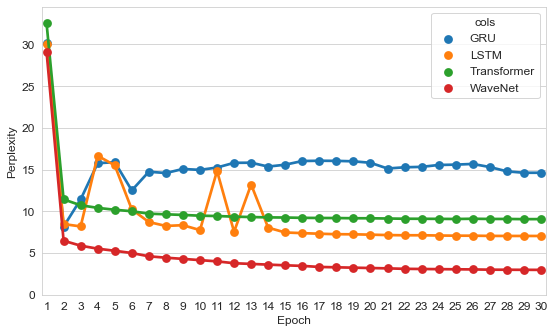

In [51]:
from os import walk, path
files = []
for (root, _, filenames) in walk('./results'):
    files.extend(list(map(lambda x: path.join(root, x), filenames)))

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(7,4))
networks = []
data = pd.DataFrame()
for file in files:
    network = file[::-1][file[::-1].find('.')+1:file[::-1].find('\\')][::-1]
    newData = pd.read_csv(file, sep=';', comment='#')
    data['Epoch'] = newData['Epoch']
    data[network] = newData['Valid_loss']
sns.pointplot(x='Epoch', y='vals', hue='cols', data=data.melt('Epoch', var_name='cols', value_name='vals'))
plt.ylim(bottom=0)
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.tight_layout()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0, 0)
plt.show()


We see that the WaveNet significantly outperforms all other models, but also that the Transformer is outperformed by the LSTM, which is unexpected as a Transformer is preferred over an LSTM in ProGen.